In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [23]:
air_quality=pd.read_csv('/content/Delhi_Air_Quality_Data.csv')

In [24]:
air_quality.head()

,Date,Carbon_Monoxide (mg/m3),PM2.5 (µg/m3),PM10 (µg/m3),NO2 (µg/m3),NH3 (µg/m3),SO2 (µg/m3),O3 (µg/m3),Temperature (°C),Humidity (%),Wind_Speed (m/s)
0,2022-01-01,1.585008,62.278806,73.389852,54.815373,40.747290,13.561570,87.746955,14.276045,74.668208,0.708590
1,2022-01-02,0.916158,36.622834,54.167888,37.903062,9.453588,31.114584,96.944822,6.867913,45.666702,2.973514
2,2022-01-03,1.689595,96.607852,268.383566,83.077097,17.212163,23.228546,31.311283,42.807543,88.452719,2.601462
3,2022-01-04,0.507275,166.408303,109.118728,88.043694,43.479924,14.399500,38.792816,17.549410,50.409410,4.675290
4,2022-01-05,0.254835,88.011556,102.876687,70.570735,20.591118,32.181239,66.385002,22.703561,30.531399,1.658039


In [26]:
data = pd.read_csv('/content/Delhi_air_quality(2022-2024).csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)



In [27]:
features = ['PM2.5 (µg/m3)', 'PM10 (µg/m3)', 'NO2 (µg/m3)',
            'Temperature (°C)', 'Humidity (%)', 'Wind_Speed (m/s)']
target = 'PM2.5 (µg/m3)'

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[features])
scaled_data = pd.DataFrame(scaled_features, columns=features, index=data.index)


In [29]:
scaled_data[target] = scaler.fit_transform(data[[target]])

In [31]:
def create_sequences(data, target_col, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length].values)
        y.append(data[target_col].iloc[i + seq_length])
    return np.array(X), np.array(y)

target_col = 'PM2.5 (µg/m3)'  # Target is the PM2.5 for AQI prediction
X, y = create_sequences(scaled_data, target_col, seq_length)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7, 128)              │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
## to prevent overfitting

In [34]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1819 - val_loss: 0.0942
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0880 - val_loss: 0.0885
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0921 - val_loss: 0.0905
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0868 - val_loss: 0.0893
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0924 - val_loss: 0.0882
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0830 - val_loss: 0.0894
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0915 - val_loss: 0.0893
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0864 - val_loss: 0.0880
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0836 - val_loss: 0.0877
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0874 - val_loss: 0.0878
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0856 - val_loss: 0.0882
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

In [35]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


In [36]:
y_pred_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), len(features))), y_pred], axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)], axis=1))[:, -1]


In [37]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 50.17
MAE: 44.54
R²: 0.01


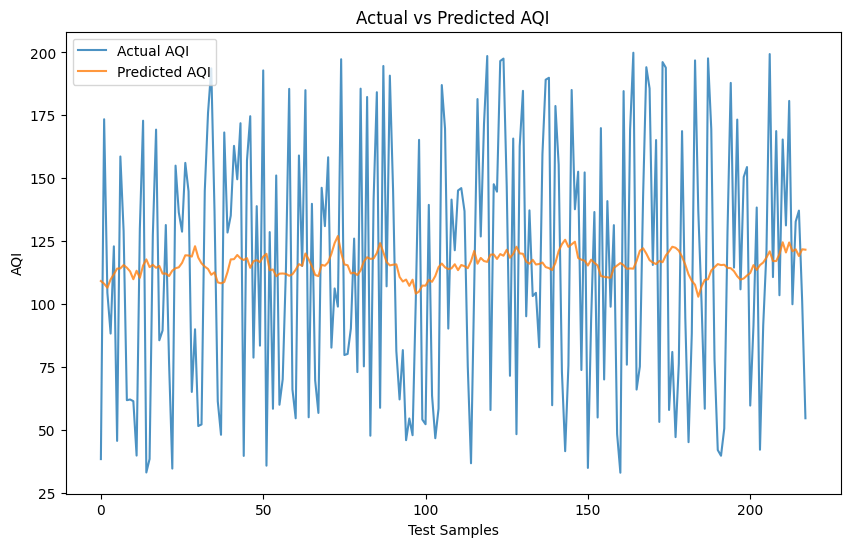

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual AQI", alpha=0.8)
plt.plot(y_pred_rescaled, label="Predicted AQI", alpha=0.8)
plt.legend()
plt.title("Actual vs Predicted AQI")
plt.xlabel("Test Samples")
plt.ylabel("AQI")
plt.show()

In [40]:
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled) * 100

# Calculate R² (Coefficient of Determination)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print Results
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² (Coefficient of Determination): {r2:.4f}")

Mean Absolute Percentage Error (MAPE): 54.60%
R² (Coefficient of Determination): 0.0118
